In [ ]:
import numpy as np
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.interpolate import interp1d
from scipy.signal import detrend, welch, windows
from obspy.signal.util import next_pow_2
import os
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

In [2]:
recording_name = 'rri_098'
session = 'session_A'
full_recording = pd.read_csv(f'corrected_recordings/{session}/{recording_name}.csv',delimiter=',')

# Retrieve RR data
RR = np.array([float(i) for i in full_recording['data'][1:]])

# Convert from milliseconds to seconds
RR_seconds = RR/1000

# The last value should tell us how many seconds passed from the beginning to the end of the recordings
RR_cumsum = np.cumsum(RR_seconds)

In [ ]:
# Find the relavant segments
# Writing of this code was assisted by Copilot

# 1) Read the recording start time from the first row of the csv file
starttime_str = full_recording['data'][0]          # e.g. "STARTTIME=02.09.2025 15:03.24.968000"
starttime_str = starttime_str.split('=')[1]        # take only date + time

# Parse to datetime (same format as in the file)
rec_start = datetime.strptime(starttime_str, "%d.%m.%Y %H:%M:%S.%f")

# 2) Define start times for each condition (from the session description for session A)
#    (we only use the start time because we'll take the first 5 minutes anyway)
event_times = {
    'baseline':      "15:05:33",
    'game1_bingo':   "15:14:40",
    'game2_island':  "15:36:53",
    'game3_tower':   "15:52:17",
}

# 3) Function that converts "HH:MM:SS" to seconds since recording start
def time_to_offset_sec(clock_time_str):
    # Use the same date as in STARTTIME (rec_start already contains it)
    date_str = rec_start.strftime("%d.%m.%Y")
    dt = datetime.strptime(f"{date_str} {clock_time_str}", "%d.%m.%Y %H:%M:%S")
    return (dt - rec_start).total_seconds()

# 4) We'll only use the first 5 minutes (300 seconds) of each condition
condition_duration = 5 * 60  # 5 minutes in seconds

segments = {}   # store index ranges for each condition

for cond_name, clock_time in event_times.items():
    start_sec = time_to_offset_sec(clock_time)           # seconds since recording start
    end_sec   = start_sec + condition_duration           # + 5 min
    
    # Find the indices in RR_cumsum that fall within this time interval
    idx_start = np.searchsorted(RR_cumsum, start_sec)
    idx_end   = np.searchsorted(RR_cumsum, end_sec)
    
    segments[cond_name] = (idx_start, idx_end)

segments

{'baseline': (162, 536),
 'game1_bingo': (868, 1364),
 'game2_island': (2921, 3342),
 'game3_tower': (4294, 4713)}

In [ ]:
# Condition to analyze
condition_to_analyze = 'game1_bingo'   # 'game1_bingo', 'game2_island', 'game3_tower'

idx_start, idx_end = segments[condition_to_analyze]

# RR data for the selected condition
RR_data = RR_seconds[idx_start:idx_end]

print(condition_to_analyze, idx_start, idx_end, len(RR_data))

game1_bingo 868 1364 496


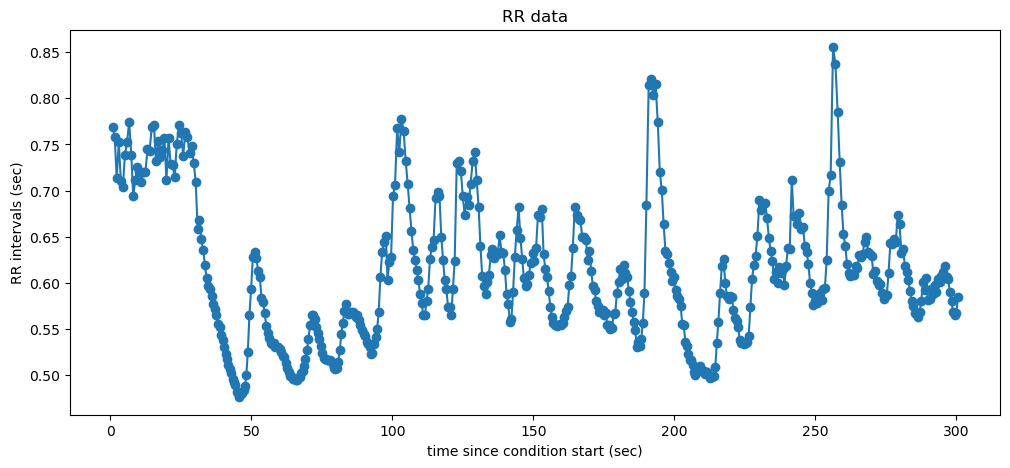

In [5]:
timestamp = np.cumsum(RR_data)

plt.figure(figsize = (12,5))
plt.plot(timestamp, RR_data, '-o')
plt.title('RR data')
plt.ylabel('RR intervals (sec)')
plt.xlabel('time since condition start (sec)')
plt.show()

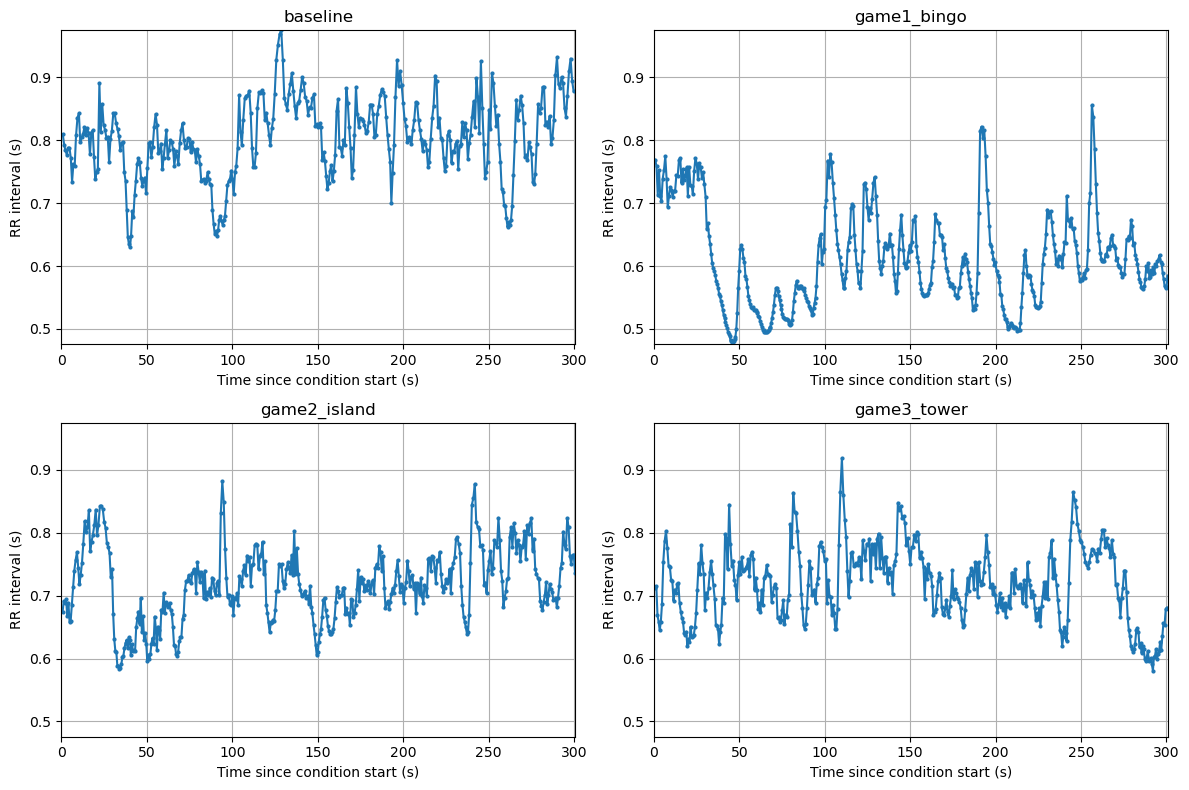

In [ ]:

conditions_order = ['baseline', 'game1_bingo', 'game2_island', 'game3_tower']

# First: find global min/max for RR and time
RR_min = float('inf')
RR_max = float('-inf')
T_max = 0

segments_data = {}

for cond in conditions_order:
    idx_start, idx_end = segments[cond]
    RR_seg = RR_seconds[idx_start:idx_end]
    t_seg = np.cumsum(RR_seg)

    segments_data[cond] = (t_seg, RR_seg)

    # Update global axis limits
    RR_min = min(RR_min, RR_seg.min())
    RR_max = max(RR_max, RR_seg.max())
    T_max = max(T_max, t_seg.max())

# Now make plots with the same axes
plt.figure(figsize=(12, 8))

for i, cond in enumerate(conditions_order, 1):
    t_seg, RR_seg = segments_data[cond]

    plt.subplot(2, 2, i)
    plt.plot(t_seg, RR_seg, '-o', markersize=2)
    plt.title(cond)

    # Shared axes
    plt.xlim(0, T_max)
    plt.ylim(RR_min, RR_max)

    plt.xlabel('Time since condition start (s)')
    plt.ylabel('RR interval (s)')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [7]:
# Interpolate
f = interp1d(timestamp, RR_data, 'linear')

# Sample rate for interpolation
fs = 10.0
steps = 1 / fs

# Now we can sample from interpolation function
timeindex_inter = np.arange(np.min(timestamp), np.max(timestamp), steps)
rr_interpolated = f(timeindex_inter)

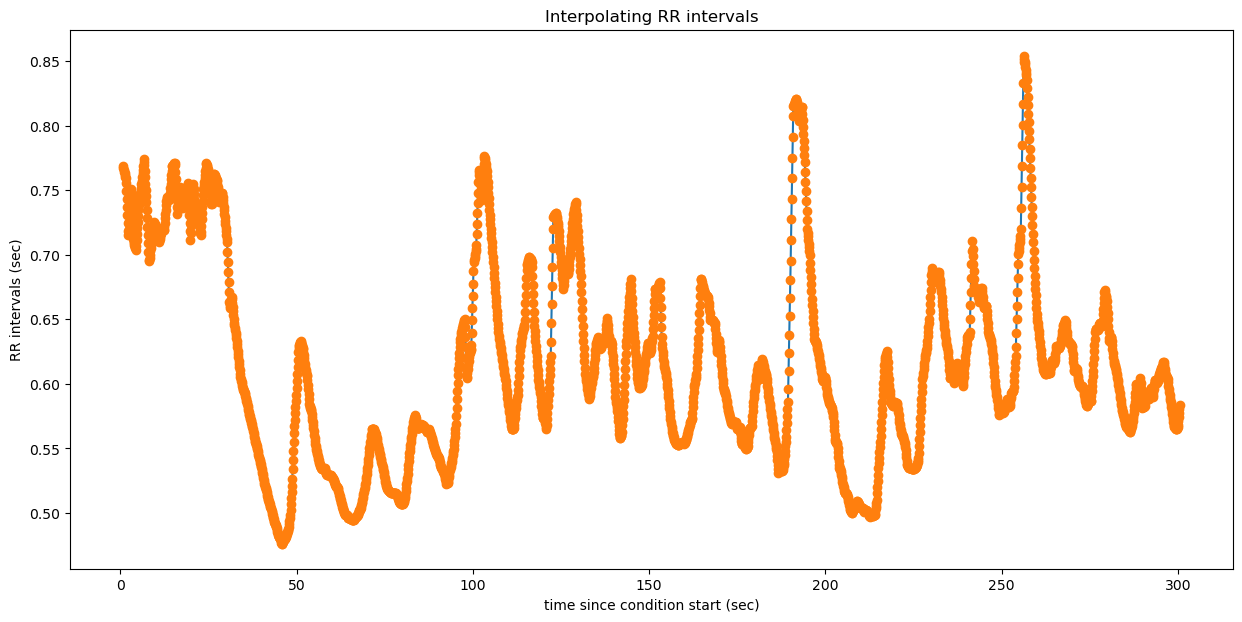

In [8]:
# Plotting
plt.figure(figsize = (15,7))
plt.plot(timestamp, RR_data,label='original data')
plt.plot(timeindex_inter, rr_interpolated, 'o',label='interpolated data')
plt.ylabel('RR intervals (sec)')
plt.xlabel('time since condition start (sec)')
plt.title('Interpolating RR intervals')
plt.show()

=== Analyserer PSD for: baseline ===


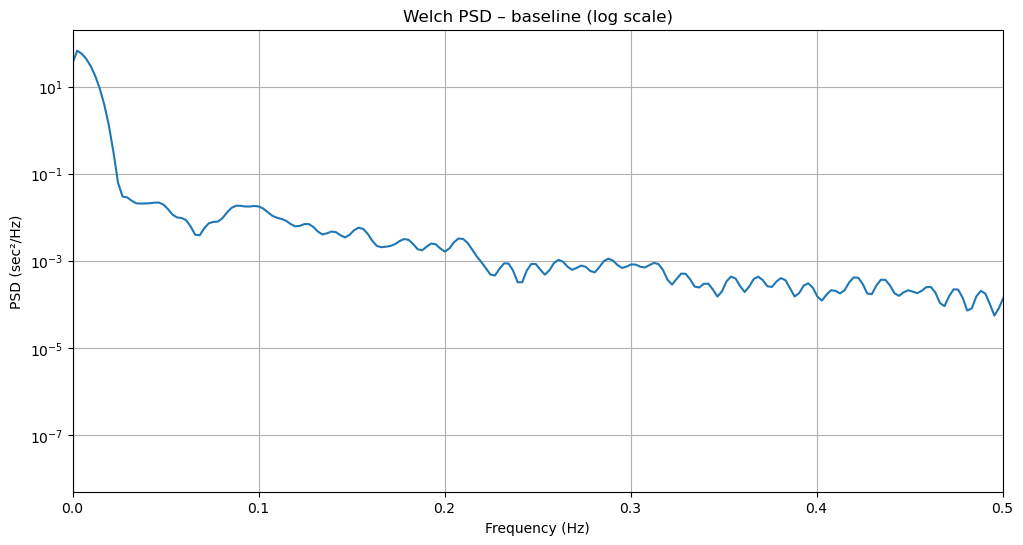

=== Analyserer PSD for: game1_bingo ===


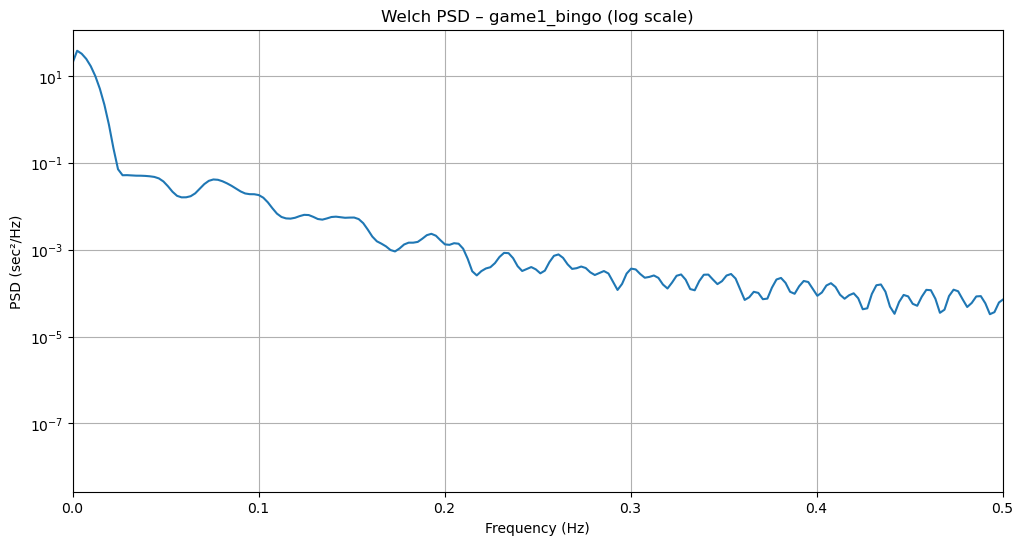

=== Analyserer PSD for: game2_island ===


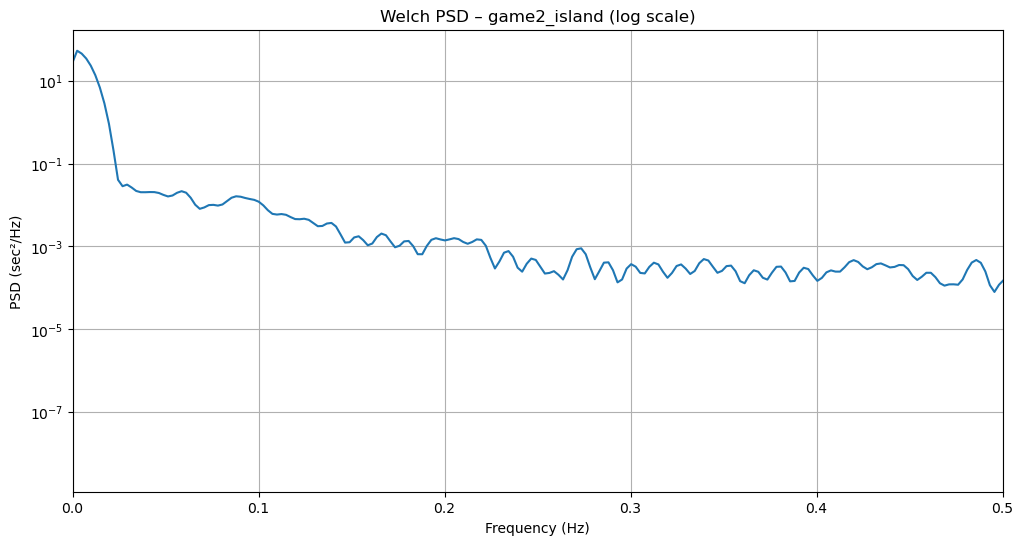

=== Analyserer PSD for: game3_tower ===


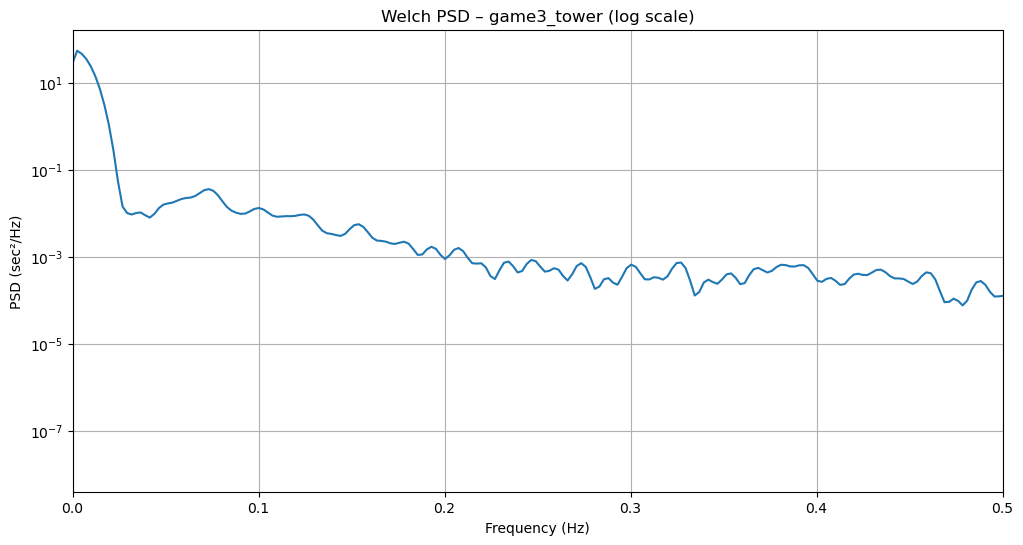

In [ ]:
def next_pow_2(n):
    return 1<<(n-1).bit_length()

fs = 10.0
steps = 1 / fs

for cond in conditions_order:

    print(f"=== Analyzing PSD for: {cond} ===")

    # Extract RR
    idx_start, idx_end = segments[cond]
    RR_data = RR_seconds[idx_start:idx_end]

    timestamp = np.cumsum(RR_data)
    timestamp = timestamp - timestamp[0]

    # Interpolation
    f = interp1d(timestamp, RR_data, 'linear')
    t_interp = np.arange(0, timestamp[-1], steps)
    rr_interpolated = f(t_interp)

    # Welch PSD
    window = windows.hamming(len(rr_interpolated)//4)
    nfft = next_pow_2(len(rr_interpolated))

    freqs, psd = welch(
        rr_interpolated,
        fs=fs,
        window=window,
        nfft=nfft,
        scaling='density',
        return_onesided=True,
        detrend=False
    )

    # Plotting
    plt.figure(figsize=(12,6))
    plt.semilogy(freqs, psd)
    plt.title(f"Welch PSD – {cond} (log scale)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("PSD (sec²/Hz)")
    plt.grid(True)
    plt.xlim(0, 0.5)
    plt.show()

In [ ]:
# HF band boundaries
hf_low = 0.15
hf_high = 0.40

# Boolean mask for HF frequencies
hf_mask = (freqs >= hf_low) & (freqs <= hf_high)

# Integrate PSD over the HF band
HF_power = np.trapz(psd[hf_mask], freqs[hf_mask])

print(f"HF-HRV ({hf_low}-{hf_high} Hz) for {condition_to_analyze}: {HF_power}")

HF-HRV (0.15-0.4 Hz) for game1_bingo: 0.00021875960932867927


In [ ]:
conditions_order = ['baseline', 'game1_bingo', 'game2_island', 'game3_tower']
hf_results = {}

def next_pow_2(n):
    return 1<<(n-1).bit_length()

for cond in conditions_order:
    idx_start, idx_end = segments[cond]
    RR_cond = RR_seconds[idx_start:idx_end]

    # interpolation
    timestamp = np.cumsum(RR_cond)
    time_rel = timestamp - timestamp[0]

    fs = 10
    steps = 1/fs

    f = interp1d(time_rel, RR_cond, kind='linear')
    t_interp = np.arange(time_rel[0], time_rel[-1], steps)
    rr_interp = f(t_interp)

    # Welch PSD
    window = windows.hamming(len(rr_interp)//4)
    nfft = next_pow_2(len(rr_interp))

    freqs, psd = welch(
        rr_interp,
        fs=fs,
        window=window,
        nfft=nfft,
        scaling='density',
        return_onesided=True,
        detrend=False
    )

    # HF integration
    hf_low, hf_high = 0.15, 0.40
    hf_mask = (freqs >= hf_low) & (freqs <= hf_high)
    HF_power = np.trapz(psd[hf_mask], freqs[hf_mask])

    hf_results[cond] = HF_power

hf_results

{'baseline': 0.00028071092689595744,
 'game1_bingo': 0.00016898491063033422,
 'game2_island': 0.000152858810404168,
 'game3_tower': 0.00021875960932867927}

In [ ]:
lf_results = {}

lf_low, lf_high = 0.04, 0.15
hf_low, hf_high = 0.15, 0.40

for cond in conditions_order:
    idx_start, idx_end = segments[cond]
    RR_cond = RR_seconds[idx_start:idx_end]

    # interpolation
    timestamp = np.cumsum(RR_cond)
    time_rel = timestamp - timestamp[0]

    fs = 10
    steps = 1/fs

    f = interp1d(time_rel, RR_cond, kind='linear')
    t_interp = np.arange(time_rel[0], time_rel[-1], steps)
    rr_interp = f(t_interp)

    # Welch PSD
    window = windows.hamming(len(rr_interp)//4)
    nfft = next_pow_2(len(rr_interp))

    freqs, psd = welch(
        rr_interp,
        fs=fs,
        window=window,
        nfft=nfft,
        scaling='density',
        return_onesided=True,
        detrend=False
    )

    # LF integration
    lf_mask = (freqs >= lf_low) & (freqs <= lf_high)
    LF_power = np.trapz(psd[lf_mask], freqs[lf_mask])
    lf_results[cond] = LF_power

    # HF integration (if you also want to update hf_results here)
    hf_mask = (freqs >= hf_low) & (freqs <= hf_high)
    HF_power = np.trapz(psd[hf_mask], freqs[hf_mask])
    hf_results[cond] = HF_power

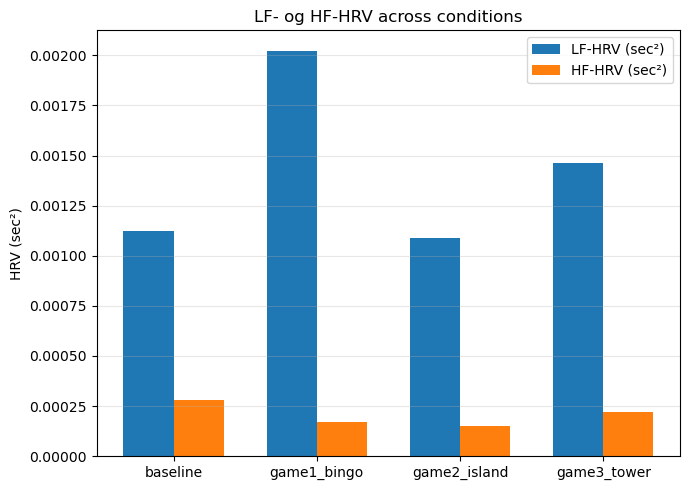

In [ ]:
plt.figure(figsize=(7,5))

conds = list(hf_results.keys())
x = np.arange(len(conds))
width = 0.35  # width of bars

hf_sec2 = [hf_results[c] for c in conds]
lf_sec2 = [lf_results[c] for c in conds]

plt.bar(x - width/2, lf_sec2, width, label='LF-HRV (sec²)')
plt.bar(x + width/2, hf_sec2, width, label='HF-HRV (sec²)')

plt.xticks(x, conds)
plt.ylabel('HRV (sec²)')
plt.title('LF and HF HRV across conditions')
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# HRV per-participant computation: compute LF and HF power for each condition
# The output DataFrame `hrv_per_participant` will be used by subsequent tests.
# Writing of this code was assisted by Copilot

event_times_all = {
    'baseline':      '15:05:33',
    'game1_bingo':   '15:14:40',
    'game2_island':  '15:36:53',
    'game3_tower':   '15:52:17',
}
cond_order = ['baseline','game1_bingo','game2_island','game3_tower']
cond_duration = 5*60
fs = 10.0

def parse_starttime_from_df(df):
    s = df['data'][0].split('=')[1]
    parsed = None
    for fmt in ('%d.%m.%Y %H:%M.%S.%f', '%d.%m.%Y %H:%M:%S.%f'):
        try:
            parsed = datetime.strptime(s, fmt)
            break
        except Exception:
            continue
    if parsed is None:
        raise ValueError(f'Unrecognized STARTTIME format: {s}')
    return parsed

def compute_lf_hf_from_rr(rr_seconds, fs=10.0):
    if len(rr_seconds) < 10:
        return np.nan, np.nan
    t_rel = np.cumsum(rr_seconds) - np.cumsum(rr_seconds)[0]
    t_interp = np.arange(0, t_rel[-1], 1.0/fs)
    f = interp1d(t_rel, rr_seconds, kind='linear', fill_value='extrapolate')
    rr_i = f(t_interp)
    if len(rr_i) < 4:
        return np.nan, np.nan
    nfft = 1 << (len(rr_i)-1).bit_length()
    win = windows.hamming(max(4, len(rr_i)//4))
    freqs, psd = welch(rr_i, fs=fs, window=win, nfft=nfft, detrend=False, return_onesided=True, scaling='density')
    lf_mask = (freqs >= 0.04) & (freqs <= 0.15)
    hf_mask = (freqs >= 0.15) & (freqs <= 0.40)
    lf_power = np.trapz(psd[lf_mask], freqs[lf_mask]) if lf_mask.any() else np.nan
    hf_power = np.trapz(psd[hf_mask], freqs[hf_mask]) if hf_mask.any() else np.nan
    return lf_power, hf_power

rows = []
session_dir = os.path.join('corrected_recordings','session_A')
pids_list = sorted([int(fn.split('_')[1].split('.')[0]) for fn in os.listdir(session_dir) if fn.startswith('rri_') and fn.endswith('.csv')])
print('Computing LF/HF for', len(pids_list), 'participants...')
for pid in pids_list:
    fn = os.path.join(session_dir, f'rri_{pid:03d}.csv')
    try:
        df = pd.read_csv(fn, delimiter=',')
        rec_start = parse_starttime_from_df(df)
        RR = np.array([float(i) for i in df['data'][1:]]) / 1000.0
        RR_cumsum = np.cumsum(RR)
    except Exception as e:
        print('Skipping', pid, 'read error', e)
        continue
    for cond in cond_order:
        start_clock = event_times_all[cond]
        date_str = rec_start.strftime('%d.%m.%Y')
        game_start = datetime.strptime(f'{date_str} {start_clock}', '%d.%m.%Y %H:%M:%S')
        start_sec = (game_start - rec_start).total_seconds()
        end_sec = start_sec + cond_duration
        i0 = np.searchsorted(RR_cumsum, start_sec)
        i1 = np.searchsorted(RR_cumsum, end_sec)
        rr_seg = RR[i0:i1]
        lf, hf = compute_lf_hf_from_rr(rr_seg, fs=fs)
        rows.append({'pid': pid, 'condition': cond, 'LF': lf, 'HF': hf})

hrv_df = pd.DataFrame(rows)
hrv_wide = hrv_df.pivot(index='pid', columns='condition')[['LF','HF']]
hrv_wide.columns = ['_'.join(col).strip() for col in hrv_wide.columns.values]
hrv_wide = hrv_wide.reset_index()
print('Computed HRV table shape:', hrv_wide.shape)
display(hrv_wide.head())
# Save to notebook namespace
hrv_per_participant = hrv_wide

Computing LF/HF for 55 participants...
Computed HRV table shape: (55, 9)


,pid,LF_baseline,LF_game1_bingo,LF_game2_island,LF_game3_tower,HF_baseline,HF_game1_bingo,HF_game2_island,HF_game3_tower
0,2,0.001226,0.003241,0.001387,0.003060,0.000226,0.000387,0.000252,0.000429
1,8,0.001114,0.003959,0.003432,0.003009,0.000298,0.000405,0.000451,0.000377
2,9,0.002407,0.003433,0.002480,0.003027,0.000872,0.000445,0.000542,0.000427
3,14,0.003038,0.001785,0.005221,0.005500,0.006302,0.001017,0.002676,0.001985
4,15,0.003035,0.003074,0.002844,0.002757,0.000984,0.000499,0.001059,0.000552


In [ ]:
# Paired non-parametric tests (Wilcoxon) comparing each game to baseline
# Uses `hrv_per_participant` DataFrame produced by the HRV computation cell above.
# Writing of this code was assisted by Copilot

if 'hrv_per_participant' not in globals():
    print("`hrv_per_participant` not found. Run the HRV computation cell first.")
else:
    df = hrv_per_participant.copy()
    metrics = ['HF','LF']
    comparisons = [('baseline','game1_bingo'), ('baseline','game2_island'), ('baseline','game3_tower')]
    rows = []
    for metric in metrics:
        pvals = []
        for a,b in comparisons:
            col_a = f'{metric}_{a}'
            col_b = f'{metric}_{b}'
            if col_a not in df.columns or col_b not in df.columns:
                print(f'Missing columns for metric {metric}:', col_a, col_b)
                rows.append({'metric':metric,'comparison':f'{b} vs {a}','n':0,'stat':np.nan,'p':np.nan,'median_diff':np.nan})
                pvals.append(1.0)
                continue
            valid = df[[col_a,col_b]].dropna()
            if len(valid) < 5:
                stat = np.nan; p = np.nan; n = len(valid)
            else:
                stat, p = wilcoxon(valid[col_a], valid[col_b], alternative='two-sided')
                n = len(valid)
            diff_med = np.median(valid[col_b] - valid[col_a]) if len(valid)>0 else np.nan
            rows.append({'metric': metric, 'comparison': f'{b} vs {a}', 'n': n, 'stat': stat, 'p': p, 'median_diff': diff_med})
            pvals.append(1.0 if np.isnan(p) else p)
    res = pd.DataFrame(rows)
    # Bonferroni correction per metric (3 comparisons each)
    res['p_adj_bonf'] = np.nan
    for metric in metrics:
        mask = res['metric'] == metric
        pvals = res.loc[mask, 'p'].fillna(1.0).values
        if len(pvals) > 0:
            rej, p_adj, _, _ = multipletests(pvals, method='bonferroni')
            res.loc[mask, 'p_adj_bonf'] = p_adj
    display(res[['metric','comparison','n','stat','p','p_adj_bonf','median_diff']])

,metric,comparison,n,stat,p,p_adj_bonf,median_diff
0,HF,game1_bingo vs baseline,55,156.0,2.683363e-07,8.050088e-07,-0.000175
1,HF,game2_island vs baseline,55,670.0,4.021122e-01,1.000000e+00,-0.000010
2,HF,game3_tower vs baseline,55,196.0,1.514698e-06,4.544095e-06,-0.000199
3,LF,game1_bingo vs baseline,55,487.0,1.773383e-02,5.320150e-02,0.000563
4,LF,game2_island vs baseline,55,509.0,2.875705e-02,8.627114e-02,0.000386
5,LF,game3_tower vs baseline,55,702.0,5.688532e-01,1.000000e+00,0.000369


/var/folders/qm/dldysmcx5b5_8j333qgh3h7h0000gn/T/ipykernel_63741/1121834157.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['baseline','game1','game2','game3'])
/var/folders/qm/dldysmcx5b5_8j333qgh3h7h0000gn/T/ipykernel_63741/1121834157.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['baseline','game1','game2','game3'])


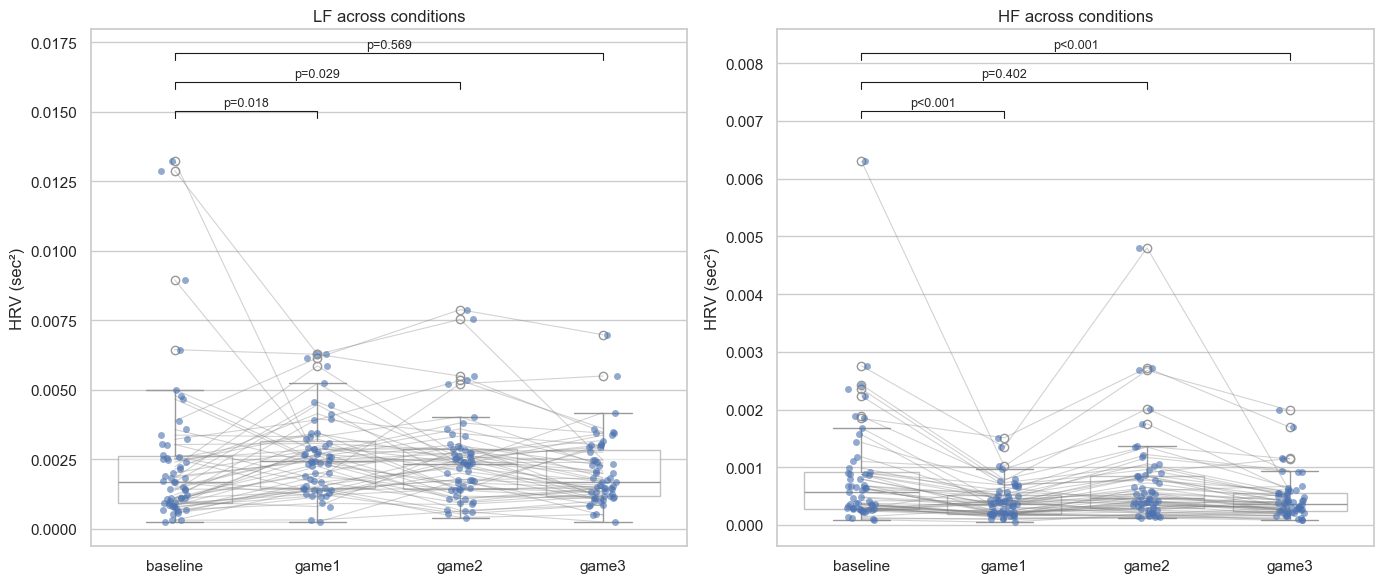

In [ ]:
# HRV summary plot placed directly under the Wilcoxon results table
# Now plotting MEDIAN + IQR (boxplots) and annotating Wilcoxon p-values (baseline vs each game)
# This code was asisted by Copilot

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon

if 'hrv_per_participant' not in globals():
    print('`hrv_per_participant` not found. Run the HRV computation cell first.')
else:
    df = hrv_per_participant.copy()
    metrics = ['LF','HF']
    conds = ['baseline','game1_bingo','game2_island','game3_tower']
    rows = []
    for _, r in df.iterrows():
        pid = r['pid']
        for m in metrics:
            for c in conds:
                col = f'{m}_{c}'
                val = r[col] if col in r.index else np.nan
                rows.append({'pid': pid, 'metric': m, 'condition': c, 'value': val})
    plot_df = pd.DataFrame(rows)
    plot_df = plot_df.dropna()
    if plot_df.empty:
        print('No HRV data available to plot.')
    else:
        sns.set(style='whitegrid')
        fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=False)
        for i, m in enumerate(metrics):
            ax = axes[i]
            sub = plot_df[plot_df['metric'] == m].copy()
            order = conds
            # boxplot shows median + IQR (robust central measure)
            sns.boxplot(x='condition', y='value', data=sub, order=order, ax=ax, color='white', showcaps=True, boxprops=dict(alpha=0.6))
            # individual points
            sns.stripplot(x='condition', y='value', data=sub, order=order, ax=ax, jitter=True, alpha=0.6, color='C0')
            # connect within-subject lines (paired)
            for pid, g in sub.groupby('pid'):
                g2 = g.set_index('condition').reindex(order).dropna()
                if len(g2) > 1:
                    x_idx = [order.index(c) for c in g2.index]
                    y = g2['value'].values
                    ax.plot(x_idx, y, color='gray', alpha=0.35, linewidth=0.8)
            # compute Wilcoxon (baseline vs each game) and annotate
            y_max = sub['value'].max() if not sub['value'].isnull().all() else 0.0
            y_min = sub['value'].min() if not sub['value'].isnull().all() else 0.0
            y_span = max(1e-12, y_max - y_min)
            annotation_y = y_max + 0.12 * y_span
            for j, c in enumerate(order[1:], start=1):
                col_base = 'baseline'
                a = sub[sub['condition'] == col_base].set_index('pid')['value']
                b = sub[sub['condition'] == c].set_index('pid')['value']
                joined = pd.concat([a, b], axis=1, join='inner').dropna()
                if len(joined) >= 5:
                    try:
                        stat, p = wilcoxon(joined.iloc[:,0], joined.iloc[:,1], alternative='two-sided')
                    except Exception:
                        p = np.nan
                else:
                    p = np.nan
                # draw annotation line and text
                x1, x2 = 0, j
                ax.plot([x1, x1, x2, x2], [annotation_y, annotation_y+0.02*y_span, annotation_y+0.02*y_span, annotation_y], color='k', linewidth=0.8)
                txt = 'n/a' if np.isnan(p) else (f'p<{0.001:.3f}' if p<0.001 else f'p={p:.3f}')
                ax.text((x1+x2)/2, annotation_y+0.025*y_span, txt, ha='center', va='bottom', fontsize=9)
                annotation_y += 0.08 * y_span
            ax.set_title(f'{m} across conditions')
            ax.set_xlabel('')
            ax.set_ylabel('HRV (sec²)')
            ax.set_xticklabels(['baseline','game1','game2','game3'])
        plt.tight_layout()
        plt.show()

# ISC analysis

In [ ]:
# Imports and helper libs
import os
import ast
from itertools import combinations
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.signal import detrend
from scipy.stats import zscore, mannwhitneyu
from datetime import datetime

# Game time windows (session A times used previously)
game_times = {
    "game2": ("15:36:53", "15:41:53"),  # Deserted Island
    "game3": ("15:52:17", "16:02:17"),  # Tower Game
}

# sample rate for interpolation
FS = 10.0
STEPS = 1.0 / FS

# find available participant files in corrected_recordings (ONLY session_A)
# Writing of this code was assisted by Copilot
base_dir = 'corrected_recordings'
pids = set()
session = 'session_A'
session_dir = os.path.join(base_dir, session)
if os.path.isdir(session_dir):
    for fn in os.listdir(session_dir):
        if fn.startswith('rri_') and fn.endswith('.csv'):
            try:
                pid = int(fn.split('_')[1].split('.')[0])
                pids.add(pid)
            except Exception:
                continue
pids = sorted(pids)
print(f'Found {len(pids)} participant files in session_A (examples):', pids[:10])

Found 55 participant files in session_A (examples): [2, 8, 9, 14, 15, 16, 18, 19, 20, 21]


In [ ]:
# Load team tables and build team maps (participant -> team label)
# Writing of this code was assisted by Copilot
def build_team_map(path):
    df = pd.read_csv(path, header=0)
    team_map = {}
    for _, row in df.iterrows():
        team_label = row.iloc[1]
        members = row.iloc[2:].dropna().astype(int).tolist()
        for m in members:
            team_map[m] = team_label
    return team_map

team_map_game2 = build_team_map('teams_sessionA_round1.csv')
team_map_game3 = build_team_map('teams_sessionA_round2.csv')

# Load friends / nonfriends lists
any_friends = ast.literal_eval(open('any_friends.txt').read()) if os.path.exists('any_friends.txt') else []
nonfriends = ast.literal_eval(open('reciprocal_nonfriends.txt').read()) if os.path.exists('reciprocal_nonfriends.txt') else []
any_friends = set(tuple(sorted(p)) for p in any_friends)
nonfriends = set(tuple(sorted(p)) for p in nonfriends)

def is_friend(a,b):
    return tuple(sorted((a,b))) in any_friends
def is_nonfriend(a,b):
    return tuple(sorted((a,b))) in nonfriends

print('Team maps sizes:', len(team_map_game2), len(team_map_game3), 'Friends example count:', len(any_friends))

Team maps sizes: 63 63 Friends example count: 550


In [ ]:
# robust loader: returns (time_rel, RR_seconds) for a given pid and game_label
# Writing of this code was assisted by Copilot
def load_rr_segment(pid, game_label):
    recording_name = f'rri_{pid:03d}.csv'
    candidates = [
        os.path.join('corrected_recordings','session_A',recording_name),
        recording_name,
    ]
    full = None
    for p in candidates:
        if os.path.exists(p):
            full = pd.read_csv(p, delimiter=',')
            break
    if full is None:
        raise FileNotFoundError(f'Could not find {recording_name} in expected locations')

    RR = np.array([float(i) for i in full['data'][1:]])
    RR_seconds = RR / 1000.0
    RR_cumsum = np.cumsum(RR_seconds)

    starttime_str = full['data'][0].split('=')[1]
    # Some files use a dot between minutes and seconds (e.g. '15:03.24.500000').
    # Try both common formats.
    parsed = None
    for fmt in ('%d.%m.%Y %H:%M.%S.%f', '%d.%m.%Y %H:%M:%S.%f'):
        try:
            parsed = datetime.strptime(starttime_str, fmt)
            break
        except Exception:
            continue
    if parsed is None:
        raise ValueError(f"Unrecognized STARTTIME format: {starttime_str}")
    rec_start = parsed

    start_clock, end_clock = game_times[game_label]
    date_str = rec_start.strftime('%d.%m.%Y')
    game_start = datetime.strptime(f'{date_str} {start_clock}', '%d.%m.%Y %H:%M:%S')
    game_end   = datetime.strptime(f'{date_str} {end_clock}',   '%d.%m.%Y %H:%M:%S')

    start_sec = (game_start - rec_start).total_seconds()
    end_sec   = (game_end   - rec_start).total_seconds()

    idx_start = np.searchsorted(RR_cumsum, start_sec)
    idx_end   = np.searchsorted(RR_cumsum, end_sec)

    RR_data = RR_seconds[idx_start:idx_end]
    time_rel = np.cumsum(RR_data) - (np.cumsum(RR_data)[0] if len(RR_data)>0 else 0)
    return time_rel, RR_data

def isc_between_pair(pid1, pid2, game_label, fs=FS):
    t1, rr1 = load_rr_segment(pid1, game_label)
    t2, rr2 = load_rr_segment(pid2, game_label)
    if len(t1) < 5 or len(t2) < 5:
        return np.nan
    T = min(t1[-1], t2[-1])
    steps = 1.0 / fs
    t_common = np.arange(0, T, steps)
    f1 = interp1d(t1, rr1, kind='linear', fill_value='extrapolate')
    f2 = interp1d(t2, rr2, kind='linear', fill_value='extrapolate')
    x1 = f1(t_common)
    x2 = f2(t_common)
    x1_d = detrend(x1)
    x2_d = detrend(x2)
    x1_z = zscore(x1_d)
    x2_z = zscore(x2_d)
    if np.isnan(x1_z).any() or np.isnan(x2_z).any():
        return np.nan
    r = np.corrcoef(x1_z, x2_z)[0,1]
    return float(r)


In [ ]:
# Compute ISC for pairs and run Mann-Whitney tests
# Writing of this code was assisted by Copilot
games = ['game2', 'game3']
results = {}
for g in games:
    team_map = team_map_game2 if g == 'game2' else team_map_game3
    isc_same = []
    isc_diff = []
    isc_friends = []
    isc_nonfriends = []

    pairs = 0
    for pid1, pid2 in combinations(pids, 2):
        if pid1 not in team_map or pid2 not in team_map:
            continue
        pairs += 1
        same_team = (team_map[pid1] == team_map[pid2])
        try:
            r = isc_between_pair(pid1, pid2, g)
        except Exception as e:
            # skip problematic pairs but keep moving
            # print('skip', pid1, pid2, e)
            continue
        if np.isnan(r):
            continue
        if same_team:
            isc_same.append(r)
            if is_friend(pid1, pid2):
                isc_friends.append(r)
            elif is_nonfriend(pid1, pid2):
                isc_nonfriends.append(r)
        else:
            isc_diff.append(r)
    
    # Mann-Whitney U: same vs diff
    isc_same_arr = np.array(isc_same)
    isc_diff_arr = np.array(isc_diff)
    valid_same = isc_same_arr[~np.isnan(isc_same_arr)]
    valid_diff = isc_diff_arr[~np.isnan(isc_diff_arr)]
    if len(valid_same) > 0 and len(valid_diff) > 0:
        u_res = mannwhitneyu(valid_same, valid_diff, alternative='two-sided')
    else:
        u_res = None

    # Friends vs nonfriends (within same team)
    f_arr = np.array(isc_friends)
    nf_arr = np.array(isc_nonfriends)
    valid_f = f_arr[~np.isnan(f_arr)]
    valid_nf = nf_arr[~np.isnan(nf_arr)]
    if len(valid_f) > 0 and len(valid_nf) > 0:
        u_fn = mannwhitneyu(valid_f, valid_nf, alternative='two-sided')
    else:
        u_fn = None

    results[g] = {
        'n_pairs_checked': pairs,
        'same_team_n': len(valid_same),
        'diff_team_n': len(valid_diff),
        'same_team_median': np.median(valid_same) if len(valid_same)>0 else np.nan,
        'diff_team_median': np.median(valid_diff) if len(valid_diff)>0 else np.nan,
        'same_vs_diff_u': u_res,
        'friends_n': len(valid_f),
        'nonfriends_n': len(valid_nf),
        'friends_median': np.median(valid_f) if len(valid_f)>0 else np.nan,
        'nonfriends_median': np.median(valid_nf) if len(valid_nf)>0 else np.nan,
        'friends_vs_nonfriends_u': u_fn
    }

results

# Print concise summary
for g, info in results.items():
    print('---', g, '---')
    print('Pairs checked:', info['n_pairs_checked'])
    print('Same-team n, median:', info['same_team_n'], info['same_team_median'])
    print('Diff-team n, median:', info['diff_team_n'], info['diff_team_median'])
    if info['same_vs_diff_u'] is not None:
        print('Mann-Whitney U same vs diff: U=%.2f, p=%.4f' % (info['same_vs_diff_u'].statistic, info['same_vs_diff_u'].pvalue))
    else:
        print('Not enough data for same vs diff test')
    print('Friends n, median:', info['friends_n'], info['friends_median'])
    print('Nonfriends n, median:', info['nonfriends_n'], info['nonfriends_median'])
    if info['friends_vs_nonfriends_u'] is not None:
        print('Mann-Whitney U friends vs nonfriends: U=%.2f, p=%.4f' % (info['friends_vs_nonfriends_u'].statistic, info['friends_vs_nonfriends_u'].pvalue))
    else:
        print('Not enough data for friends vs nonfriends test')
    print()

--- game2 ---
Pairs checked: 1485
Same-team n, median: 76 0.05962847014774057
Diff-team n, median: 1409 0.028057598864501012
Mann-Whitney U same vs diff: U=61578.00, p=0.0273
Friends n, median: 21 0.09761161728380291
Nonfriends n, median: 53 0.04264086595781217
Mann-Whitney U friends vs nonfriends: U=614.00, p=0.4943

--- game3 ---
Pairs checked: 1485
Same-team n, median: 82 0.05654751744735996
Diff-team n, median: 1403 0.008641589285256627
Mann-Whitney U same vs diff: U=73450.00, p=0.0000
Friends n, median: 20 0.0023798412368071266
Nonfriends n, median: 59 0.0820995191271095
Mann-Whitney U friends vs nonfriends: U=317.00, p=0.0021



/var/folders/qm/dldysmcx5b5_8j333qgh3h7h0000gn/T/ipykernel_63741/3272701971.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='isc', data=sub, ax=ax, palette='Set2')
/opt/homebrew/Caskroom/miniconda/base/envs/Math/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 59.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/var/folders/qm/dldysmcx5b5_8j333qgh3h7h0000gn/T/ipykernel_63741/3272701971.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='friend_status', y='isc', data=sub_fn, ax=ax2, palette='Set3')
/opt/homebrew/Caskroom/miniconda/base/envs/Math/lib/python3.11/s

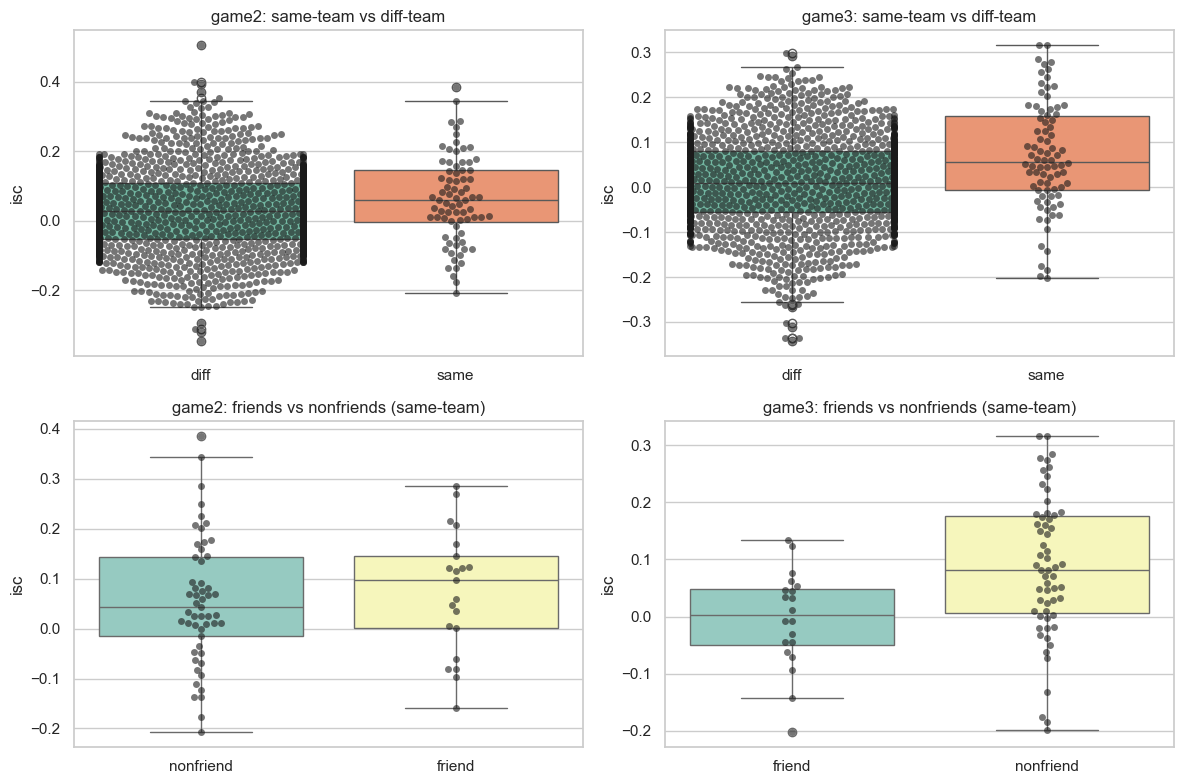

In [ ]:
# Build DataFrame with ISC per pair and type
# Writing of this code was assisted by Copilot
import seaborn as sns
import matplotlib.pyplot as plt

pairs_data = []
for g in games:
    team_map = team_map_game2 if g == 'game2' else team_map_game3
    for pid1, pid2 in combinations(pids, 2):
        if pid1 not in team_map or pid2 not in team_map:
            continue
        try:
            r = isc_between_pair(pid1, pid2, g)
        except Exception:
            continue
        if np.isnan(r):
            continue
        same_team = (team_map[pid1] == team_map[pid2])
        pairs_data.append({
            'game': g,
            'isc': r,
            'group': 'same' if same_team else 'diff',
            'friend_status': ('friend' if is_friend(pid1, pid2) else ('nonfriend' if is_nonfriend(pid1, pid2) else 'unknown'))
        })

df_isc = pd.DataFrame(pairs_data)

# Plotting: 2x2 grid: row1 same vs diff, row2 friends vs nonfriends (same-team only)
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=False)

for i, g in enumerate(games):
    ax = axes[0, i]
    sub = df_isc[df_isc['game'] == g]
    if len(sub) == 0:
        ax.text(0.5, 0.5, 'No data', ha='center')
        continue
    sns.boxplot(x='group', y='isc', data=sub, ax=ax, palette='Set2')
    sns.swarmplot(x='group', y='isc', data=sub, color='k', alpha=0.6, ax=ax)
    ax.set_title(f'{g}: same-team vs diff-team')
    ax.set_xlabel('')

    ax2 = axes[1, i]
    sub_same = sub[sub['group'] == 'same']
    # keep only friend/nonfriend known
    sub_fn = sub_same[sub_same['friend_status'].isin(['friend', 'nonfriend'])]
    if len(sub_fn) == 0:
        ax2.text(0.5, 0.5, 'No friend/nonfriend data', ha='center')
        continue
    sns.boxplot(x='friend_status', y='isc', data=sub_fn, ax=ax2, palette='Set3')
    sns.swarmplot(x='friend_status', y='isc', data=sub_fn, color='k', alpha=0.6, ax=ax2)
    ax2.set_title(f'{g}: friends vs nonfriends (same-team)')
    ax2.set_xlabel('')

plt.tight_layout()
plt.show()